In [ ]:
# 구직사이트 웹크롤링을 통한 인사이트 도출
# 1. 잡플래닛 기업 5000개를 대상으로 산업구분, 지역정보, 연봉정보, 평점 정보를 이용하여 순위 및 집계, 상관관계등을 분석
# 2. 구직사이트(잡코리아, 사람인)를 크롤링하여 관심직군의 키워드를 워드클라우드로 표현

In [1]:
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Selenium을 활용한 크롤링 (수집/저장)

In [2]:
browser = Chrome() #브라우저 실행

In [ ]:
# for문, Selenium을 활용한 데이터 크롤링 (잡플래닛 기업랭킹 페이지 1~500)
new_list = []
for pg in np.arange(401,501):
    my_list = []
    my_list2 = []
    browser.get("https://www.jobplanet.co.kr/companies?page="f"{pg}")
    menus = browser.find_elements(By.CSS_SELECTOR, '#listCompanies section.company.content_ty3 dl dt')
    menus2 = browser.find_elements(By.CSS_SELECTOR, '#listCompanies section.company.content_ty3 dl dd')
    for c in menus:
        my_list.append(c.text.replace("\n", "").replace("following","").strip())
    for d in menus2:
        my_list2.append(d.text.replace("\n", "").replace("following","").strip())
    for com, ind_reg, sal, rev, rate in zip(my_list[0: : 2], my_list2[0: :4], my_list2[3: :4], my_list[1: : 2], my_list2[2: :4]):
        rev = rev.replace("개의 리뷰", "")
        rate = rate.replace("평점", "")
        industry = ind_reg.split("|")[0].strip()
        region = ind_reg.split("|")[1].strip()
        salary = sal.replace("평균", "").replace(" 만원", "")
        new_list.append([com, industry, region, salary, rev, rate])
new_list

In [ ]:
browser.close() #브라우저 종료

In [ ]:
page_100 = pd.DataFrame(new_list) #페이지 1~100 df 만들기
page_100

In [ ]:
page_301_400 = pd.DataFrame(new_list) #페이지 301~400 df 만들기
page_301_400

In [ ]:
page_401_500 = pd.DataFrame(new_list) #페이지 401~500 df 만들기
page_401_500

In [3]:
# 100페이지 단위로 피클에 저장
import pickle

In [120]:
with open('data-files/combined_df.pickle', 'wb') as f: #저장
    pickle.dump(combined_df, f)

In [4]:
with open('data-files/combined_df.pickle', "rb") as f: #파일 꺼내기
    combined_df = pickle.load(f)

# 팀원과 100페이지 단위로 나눠서 피클 저장 후 서로 공유 -> 이후 1~500페이지까지 concat한 작업은 실행했으나, 과정 코드는 생략

# DB에 데이터 저장

In [ ]:
import cx_Oracle as cx
import oracledb

In [ ]:
# 초기화
oracledb.init_oracle_client()

In [ ]:
# 데이터베이스에 연결
conn = oracledb.connect(user="lab02", password="lab02", dsn="127.0.0.1:1521/xe")

In [ ]:
# DB에 넣기 위해 df -> list 형식으로 변환
combined_df_list = combined_df.values.tolist()

In [ ]:
# 명령 SQL 실행
cursor = conn.cursor()

cursor.executemany("insert into company_5000 values(:1, :2, :3, :4, :5, :6)", combined_df_list)
# for문 대신

cursor.execute("commit")

# 연결종료
conn.close()

# 데이터 전처리 및 시각화

In [5]:
# Column 명 수정
old_col_list = list(combined_df.columns)
new_col_list = ['company', 'industry', 'area', 'salary', 'review', 'rating']

new_col_dict = {}
for old, new in zip(old_col_list, new_col_list):
    new_col_dict.update({old: new})

combined_df.rename(columns= new_col_dict, inplace=True)

In [6]:
# 자료형 변환 및 None 값 없음으로 변환
combined_df['salary'] = combined_df['salary'].map(lambda x: int(str(x).replace(",","")))
combined_df['review'] = combined_df['review'].map(lambda x: int(str(x).replace(",","")))
combined_df['rating'] = combined_df['rating'].map(lambda x: float(str(x).replace(",","")))

combined_df['area'].fillna("없음", inplace = True)

In [7]:
combined_df.sort_values(by='salary', ascending=False)

,company,industry,area,salary,review,rating
2601,라이온코리아(주),제조/화학,서울,740980000,136,3.1
2949,라이언앤코(주),기관/협회,서울,110000000,121,3.0
1092,한국평가데이터(주),서비스업,서울,99800000,272,3.3
2927,맥킨지인코포레이티드한국지점,기관/협회,서울,90310000,122,4.3
1174,더보스톤컨설팅그룹인터내셔날인크,기관/협회,서울,88280000,258,4.1
...,...,...,...,...,...,...
4597,엔씨티,IT/웹/통신,서울,21870000,75,1.9
4713,(주)뷰티르샤,유통/무역/운송,서울,21590000,72,1.9
3974,서울시보건환경연구원,기관/협회,서울,21430000,88,4.2
3899,폴리큐브(주),IT/웹/통신,서울,20960000,90,1.9


In [10]:
combined_df[combined_df['area'] == '경북'].sort_values(by='salary', ascending =False)

,company,industry,area,salary,review,rating
3726,(재)포항산업과학연구원,기관/협회,경북,63940000,94,3.7
316,(주)포스코이앤씨,건설업,경북,55800000,594,3.5
701,한화시스템(주),제조/화학,경북,55570000,363,3.4
44,포스코홀딩스(주),제조/화학,경북,55240000,1626,3.3
104,한국수력원자력(주),제조/화학,경북,55180000,1122,4.0
2932,제일모직(주),유통/무역/운송,경북,54100000,122,3.1
999,(주)포스코퓨처엠,제조/화학,경북,52820000,291,3.5
2018,현대아이에이치엘(주),제조/화학,경북,52740000,170,2.8
3470,에코플라스틱(주),제조/화학,경북,52350000,103,3.1
1175,아진산업(주),제조/화학,경북,49930000,258,2.6


In [238]:
test1[test1 > 1]

company
(주)데이타솔루션    2
(주)드림텍       2
(주)오토닉스      2
영풍전자(주)      2
Name: company, dtype: int64

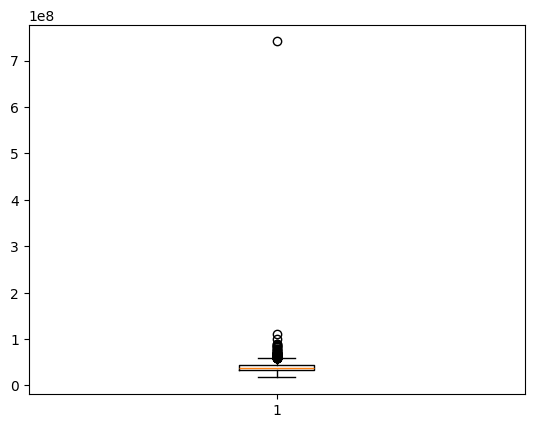

In [10]:
plt.boxplot(combined_df['salary'])
plt.show()

In [12]:
combined_df['salary'] = combined_df['salary']/10000

In [13]:
combined_df2 = combined_df[combined_df['company'] != "라이온코리아(주)"]
combined_df2.groupby(by='industry')['salary'].mean()

industry
IT/웹/통신     3808.640509
건설업         4193.071856
교육업         3374.296089
기관/협회       4087.910781
미디어/디자인     3447.014327
서비스업        3283.530997
유통/무역/운송    3848.848631
은행/금융업      4911.282723
의료/제약/복지    3907.801347
제조/화학       3982.302730
Name: salary, dtype: float64

In [14]:
# 평균 값 넣어주기
combined_df2['salary'] = combined_df2['salary'].replace(74098, 3982)

C:\Users\geon0\AppData\Local\Temp\ipykernel_22740\3415682531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df2['salary'] = combined_df2['salary'].replace(74098, 3982)


# 분석

In [15]:
# a. 평점/연봉 높은 기업 top 10
combined_df2.sort_values(by='rating', ascending=False).head(10)

,company,industry,area,salary,review,rating
4222,페이스북코리아(유),IT/웹/통신,서울,8680.0,83,4.5
3564,(주)핫셀러,IT/웹/통신,서울,4675.0,100,4.4
4484,라이엇게임즈코리아,IT/웹/통신,해외,5979.0,77,4.4
3369,애터미(주),유통/무역/운송,충남,5030.0,106,4.4
3175,네이버웹툰,IT/웹/통신,경기,5209.0,113,4.3
776,한국중부발전(주),제조/화학,충남,4499.0,341,4.3
1328,구글코리아(유),IT/웹/통신,서울,7033.0,234,4.3
2927,맥킨지인코포레이티드한국지점,기관/협회,서울,9031.0,122,4.3
695,한국남동발전(주),제조/화학,경남,5040.0,365,4.3
407,한국가스공사,제조/화학,대구,4898.0,515,4.2


In [16]:
# industry별 평점 group by
df = combined_df2.groupby(by= 'industry')["rating"].mean().round(1)
df = df.sort_values(ascending=False)
df

industry
기관/협회       3.0
은행/금융업      3.0
교육업         2.8
IT/웹/통신     2.7
건설업         2.7
미디어/디자인     2.7
서비스업        2.6
유통/무역/운송    2.6
의료/제약/복지    2.6
제조/화학       2.6
Name: rating, dtype: float64

In [191]:
test = pd.DataFrame(df)
x = test.index
y = test['rating'].values

In [20]:
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams['axes.unicode_minus'] = False

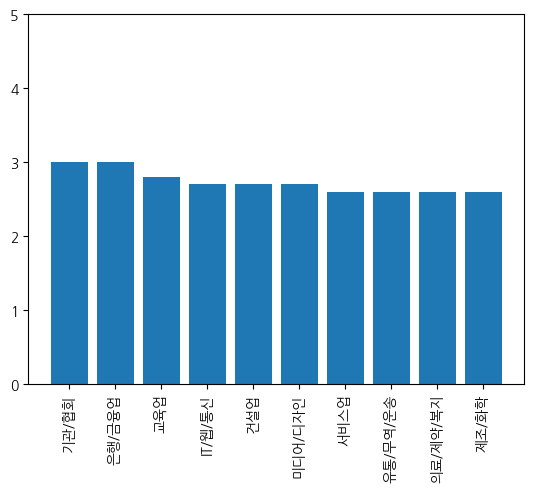

In [197]:
# 산업별 평균 평점
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.show()

[]

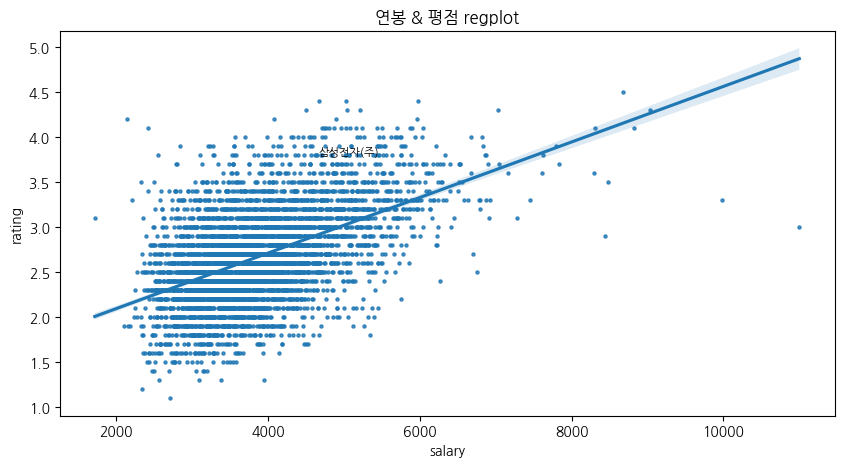

In [21]:
# 연봉 & 평점 regression plot
plt.figure(figsize=[10,5])
sns.regplot(x='salary', y='rating', scatter_kws={'s': 5}, data=combined_df2)
plt.title("연봉 & 평점 regplot")
plt.plot()

In [220]:
import scipy.stats

In [221]:
# 연봉 & 평점 상관계수
scipy.stats.pearsonr(combined_df2['salary'], combined_df2['rating'])

PearsonRResult(statistic=0.5103972983613309, pvalue=0.0)

[]

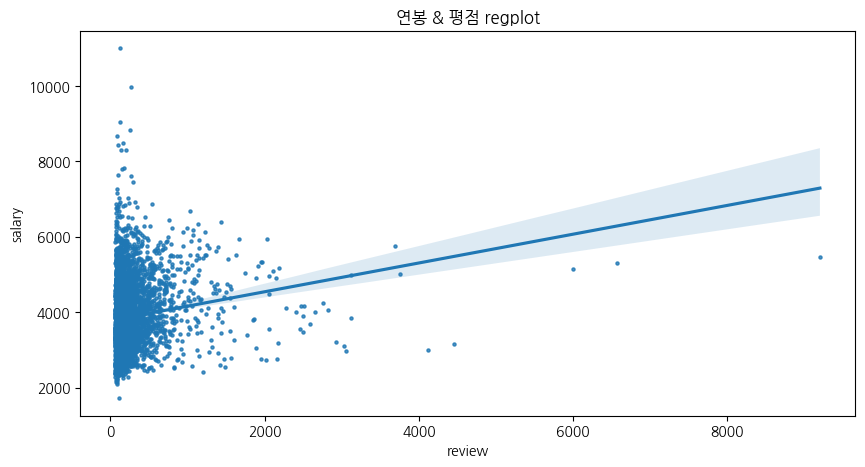

In [23]:
# 연봉 & 평점 regression plot
plt.figure(figsize=[10,5])
sns.regplot(x='review', y='salary', scatter_kws={'s': 5}, data=combined_df2)
plt.title("연봉 & 평점 regplot")
plt.plot()